In [161]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [162]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)
pd.set_option('display.precision', 2)

In [163]:
df = pd.read_csv('C:/Users/Инна/Desktop/otus/Sample - Superstore.csv', encoding='Windows-1252')

Таргет: Столбец Profit.
Признаки: 
Тип задачи: Регрессия.

In [164]:
df[df['Profit']>=3000] #уберем из датасета строки с выбросами по признаку Profit

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
509,510,CA-2015-145352,3/16/2015,3/22/2015,Standard Class,CM-12385,Christopher Martinez,Consumer,United States,Atlanta,Georgia,30318,South,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind,6354.95,5,0.0,3177.47
2623,2624,CA-2017-127180,10/22/2017,10/24/2017,First Class,TA-21385,Tom Ashbrook,Home Office,United States,New York City,New York,10024,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.97,4,0.2,3919.99
4098,4099,CA-2014-116904,9/23/2014,9/28/2014,Standard Class,SC-20095,Sanjit Chand,Consumer,United States,Minneapolis,Minnesota,55407,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.95,5,0.0,4630.48
4190,4191,CA-2017-166709,11/17/2017,11/22/2017,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,Delaware,19711,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.97,3,0.0,5039.99
6826,6827,CA-2016-118689,10/2/2016,10/9/2016,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,Indiana,47905,Central,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.95,5,0.0,8399.98
8153,8154,CA-2017-140151,3/23/2017,3/25/2017,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,Washington,98115,West,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.96,4,0.0,6719.98
9039,9040,CA-2016-117121,12/17/2016,12/21/2016,Standard Class,AB-10105,Adrian Barton,Consumer,United States,Detroit,Michigan,48205,Central,OFF-BI-10000545,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.74,13,0.0,4946.37


In [165]:
#уберем из датасета строки где аномальная продажи (если они остались)
rows_to_drop2 = df[df['Sales'] >= 17000].index
df = df.drop(rows_to_drop2)

In [166]:
rows_to_drop = df[df['Profit'] >= 3000].index
df = df.drop(rows_to_drop)

In [167]:
df[df['Profit']>=3000]
df[df['Sales']>=17000]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


In [168]:
print(df.isnull().sum().sum())

0


In [169]:
# Преобразование столбца 'Order Date' в формат datetime 
import pandas as pd
try:
    df['Order Date'] = pd.to_datetime(df['Order Date'])
except ValueError:
    print("Ошибка: не удалось преобразовать 'Order Date' в формат даты.  Проверьте формат данных в столбце.")
    exit()

df['Order Date'].head(3)

0   2016-11-08
1   2016-11-08
2   2016-06-12
Name: Order Date, dtype: datetime64[ns]

In [170]:
df['Month'] = df['Order Date'].dt.month_name()
df['Year'] = df['Order Date'].dt.year
df['Year'].head(3)

0    2016
1    2016
2    2016
Name: Year, dtype: int32

In [171]:
#удалим ненужные данные

# Список столбцов для удаления (добавьте все нужные)
columns_to_drop = [col for col in df.columns 
                  if 'ID' in col
                   or 'Date' in col
                   or 'id' in col
                   or 'Postal Code' in col
                   or 'Customer Name' in col
                   or 'Country' in col
                   or 'City' in col
                   or 'Product Name' in col
                   or 'State' in col]

# Удаляем выбранные столбцы
df_filtered = df.drop(columns=columns_to_drop)

print(f'''
Удалены столбцы:
{columns_to_drop}
''')
print(f'''
Оставшиеся столбцы:
{df_filtered.columns.tolist()}
''')


Удалены столбцы:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'Customer Name', 'Country', 'City', 'State', 'Postal Code', 'Product ID', 'Product Name']


Оставшиеся столбцы:
['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit', 'Month', 'Year']



In [172]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt  # Для визуализации

In [173]:
#преобразуем категориальные признаки (кроме Ship Mode т.к. там необходимо устнаовить класс доставки по возрастанию - от низкого до высокого)
df_filtered = pd.get_dummies(df_filtered, columns=['Category', 'Segment','Sub-Category', 'Region','Month', 'Year'])
df_filtered.head(3)#сделать это до разделения на трейн и тест!!!!!!!

,Ship Mode,Sales,Quantity,Discount,Profit,Category_Furniture,Category_Office Supplies,Category_Technology,Segment_Consumer,Segment_Corporate,Segment_Home Office,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Region_Central,Region_East,Region_South,Region_West,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Year_2014,Year_2015,Year_2016,Year_2017
0,Second Class,261.96,2,0.0,41.91,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1,Second Class,731.94,3,0.0,219.58,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
2,Second Class,14.62,2,0.0,6.87,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False


In [174]:
#преобразуем категориальные признаки по столбцу Ship Mode
df_filtered['Ship Mode'].unique()

array(['Second Class', 'Standard Class', 'First Class', 'Same Day'], dtype=object)

In [175]:
ship_mode_mapping = {'Same Day': 1, 'First Class': int(2), 'Second Class': 3, 'Standard Class': 4}
df_filtered['Ship Mode'] = df_filtered['Ship Mode'].map(ship_mode_mapping)
df_filtered.head(3)

,Ship Mode,Sales,Quantity,Discount,Profit,Category_Furniture,Category_Office Supplies,Category_Technology,Segment_Consumer,Segment_Corporate,Segment_Home Office,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Region_Central,Region_East,Region_South,Region_West,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Year_2014,Year_2015,Year_2016,Year_2017
0,3,261.96,2,0.0,41.91,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1,3,731.94,3,0.0,219.58,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
2,3,14.62,2,0.0,6.87,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False


In [176]:
X = df_filtered.drop('Profit', axis=1)
y = df_filtered['Profit']

In [177]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [178]:

# Получаем список названий столбцов
column_names = df_filtered.columns.tolist()

# Объединяем названия столбцов в строку, разделяя запятой и пробелом
column_names_string = ', '.join(column_names)

# Выводим строку
print(column_names_string)
type(column_names)

feature_names=['Ship Mode', 'Sales, Quantity', 'Discount', 'Profit', 'Category_Furniture', 'Category_Office Supplies', 'Category_Technology', 'Segment_Consumer', 'Segment_Corporate', 'Segment_Home Office', 'Sub-Category_Accessories', 'Sub-Category_Appliances', 'Sub-Category_Art', 'Sub-Category_Binders', 'Sub-Category_Bookcases', 'Sub-Category_Chairs', 'Sub-Category_Copiers', 'Sub-Category_Envelopes', 'Sub-Category_Fasteners', 'Sub-Category_Furnishings', 'Sub-Category_Labels', 'Sub-Category_Machines', 'Sub-Category_Paper', 'Sub-Category_Phones', 'Sub-Category_Storage', 'Sub-Category_Supplies', 'Sub-Category_Tables', 'Region_Central', 'Region_East', 'Region_South', 'Region_West', 'Month_April', 'Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May', 'Month_November', 'Month_October', 'Month_September', 'Year_2014', 'Year_2015', 'Year_2016', 'Year_2017']

Ship Mode, Sales, Quantity, Discount, Profit, Category_Furniture, Category_Office Supplies, Category_Technology, Segment_Consumer, Segment_Corporate, Segment_Home Office, Sub-Category_Accessories, Sub-Category_Appliances, Sub-Category_Art, Sub-Category_Binders, Sub-Category_Bookcases, Sub-Category_Chairs, Sub-Category_Copiers, Sub-Category_Envelopes, Sub-Category_Fasteners, Sub-Category_Furnishings, Sub-Category_Labels, Sub-Category_Machines, Sub-Category_Paper, Sub-Category_Phones, Sub-Category_Storage, Sub-Category_Supplies, Sub-Category_Tables, Region_Central, Region_East, Region_South, Region_West, Month_April, Month_August, Month_December, Month_February, Month_January, Month_July, Month_June, Month_March, Month_May, Month_November, Month_October, Month_September, Year_2014, Year_2015, Year_2016, Year_2017


In [180]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Определим гиперпараметры
param_grid = {
    'max_depth': [1, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 50]
}

# Создайте экземпляр GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='r2')

# Запустите поиск
grid_search.fit(X_train, y_train)

# Выведите наилучшие параметры и наилучший результат
print("Best parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Используйте наилучшую модель для предсказаний
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R-squared on test set:{r2:.4f}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best R-squared: 0.6945416954358488
MSE: 19250.2390
R-squared on test set:0.2442


In [181]:
from sklearn.model_selection import KFold, GridSearchCV
import catboost as cb
from sklearn.datasets import make_regression


# 1. Определим модель
model = cb.CatBoostRegressor(random_state=42, learning_rate=0.01, depth=6, iterations=300, verbose=0)

# 2. Определим сетку гиперпараметров для поиска
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [6, 8, 12]
}

# 3. Определим стратегию кросс-валидации
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# 4. Создадим объект GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=cv, verbose=0)

# 5. Запустим поиск по сетке
grid_search.fit(X, y)

# 6. Выведите результаты
print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучшее значение R^2:", grid_search.best_score_)

# 7. Получите лучшую модель
best_model = grid_search.best_estimator_

Лучшие гиперпараметры: {'depth': 6, 'iterations': 300, 'learning_rate': 0.05}
Лучшее значение R^2: 0.839047893703296


In [182]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#CatBoostRegressor без преобразования данных
X = df_filtered.drop('Profit', axis=1)
y = df_filtered['Profit']

# 3. Определение категориальных признаков
# categorical_features_indices = np.where(X.dtypes != float)[0]  # Находим индексы не-числовых столбцов
categorical_features_indices = [X.columns.get_loc(col) for col in X.columns if X[col].dtype == 'object'] # Более явный способ


# 4. Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Создание Pool-объектов (необязательно, но рекомендуется)
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

# 6. Создание и обучение модели
model = CatBoostRegressor(iterations=300,
                            learning_rate=0.1,
                            depth=6,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            random_seed=42,
                            verbose=False) # verbose=False чтобы не выводить много текста

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=10) # early_stopping предотвратит переобучение

# 7. Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# 8. Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"r2_score: {r2:.4f}")


Mean Squared Error: 2956.8093
Mean Absolute Error: 17.9175
r2_score: 0.9067


In [183]:
df['Profit'].mean()

np.float64(25.172626517123973)

In [184]:
#сделаем проверку на примере конкретных данных из датасета
print(df.loc[[200]].T)

                            200
Row ID      201                
Order ID    CA-2017-105074     
Order Date  2017-06-24 00:00:00
Ship Date   6/29/2017          
Ship Mode   Standard Class     
...                    ...     
Quantity    3                  
Discount    0.2                
Profit      6.79               
Month       June               
Year        2017               

[23 rows x 1 columns]


In [185]:
data = {'Ship Mode': [4],
        'Sales': [22],
        'Quantity': [3],
        'Discount': [0.2],
        'Category_Furniture': [False],
        'Category_Office Supplies': [True],
        'Category_Technology': [False],
        'Segment_Consumer': [True],
        'Segment_Corporate': [False],
        'Segment_Home Office': [False],
        'Sub-Category_Accessories': [False],  
        'Sub-Category_Appliances': [False],  
        'Sub-Category_Art': [False],            
        'Sub-Category_Binders': [False],      
        'Sub-Category_Bookcases': [False],   
        'Sub-Category_Chairs': [False],       
        'Sub-Category_Copiers': [False],      
        'Sub-Category_Envelopes': [False],      
        'Sub-Category_Fasteners': [False],      
        'Sub-Category_Furnishings': [True],  
        'Sub-Category_Labels': [False],       
        'Sub-Category_Machines': [False],     
        'Sub-Category_Paper': [False],        
        'Sub-Category_Phones': [False],          
        'Sub-Category_Storage': [False],     
        'Sub-Category_Supplies': [False],
        'Sub-Category_Tables': [False],
        'Region_Central': [False],
        'Region_East': [True],                 
        'Region_South': [False],               
        'Region_West': [False],                 
        'Month_April': [False],                  
        'Month_August': [False],                 
        'Month_December': [False],               
        'Month_February': [False],            
        'Month_January': [False],        
        'Month_July': [False],                  
        'Month_June': [True],                   
        'Month_March': [False],                 
        'Month_May': [False],               
        'Month_November': [False],              
        'Month_October': [False],               
        'Month_September': [False],        
        'Year_2014': [False],
        'Year_2015': [False],
        'Year_2016': [False],
        'Year_2017': [True]
       }

# Создаем DataFrame из словаря
data = pd.DataFrame(data)

In [186]:
y_predict = model.predict(data)
print(y_predict)

[2.4374]


In [31]:
# # Предположим, что column_names - это Series (или столбец DataFrame)

# # 1.  Убедиться, что column_names - это Series (или выделить из DataFrame)
# if isinstance(column_names, pd.DataFrame): #Если column_names - DataFrame, возьмем столбец
#     column_names = column_names.iloc[:,0] #  Предполагаем, что столбец - первый столбец в DataFrame
# if isinstance(column_names, pd.Series):
#     # 2. Преобразовать в список строк
#     column_names = column_names.astype(str).tolist()  # Преобразование в строку, затем в список
# else:
#   print ("column_names не Series и не DataFrame")
# # 3. Используйте column_names_list в plot_tree()
# # plot_tree(clf, column_names)
# column_names


column_names не Series и не DataFrame


['Ship Mode',
 'Sales',
 'Quantity',
 'Discount',
 'Profit',
 'Category_Furniture',
 'Category_Office Supplies',
 'Category_Technology',
 'Segment_Consumer',
 'Segment_Corporate',
 'Segment_Home Office',
 'Sub-Category_Accessories',
 'Sub-Category_Appliances',
 'Sub-Category_Art',
 'Sub-Category_Binders',
 'Sub-Category_Bookcases',
 'Sub-Category_Chairs',
 'Sub-Category_Copiers',
 'Sub-Category_Envelopes',
 'Sub-Category_Fasteners',
 'Sub-Category_Furnishings',
 'Sub-Category_Labels',
 'Sub-Category_Machines',
 'Sub-Category_Paper',
 'Sub-Category_Phones',
 'Sub-Category_Storage',
 'Sub-Category_Supplies',
 'Sub-Category_Tables',
 'Region_Central',
 'Region_East',
 'Region_South',
 'Region_West',
 'Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Year_2014',
 'Year_2015',
 'Year_2016',
 'Year_2017']

In [187]:
model = RandomForestRegressor(max_depth=12, min_samples_leaf= 1, min_samples_split= 5, n_jobs=-1, n_estimators=10, oob_score=True)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_split=5, n_estimators=10,
                      n_jobs=-1, oob_score=True)

In [33]:
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {r2_score(model.predict(X_test), y_test):.4f}')

Test score estimate using Out-of-bag score 0.6402
Actual test score: 0.8630


In [64]:
y_test_list=list(y_test)

pandas.core.frame.DataFrame

In [66]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import d2_absolute_error_score

model = RandomForestRegressor(max_depth=20, min_samples_leaf= 1, min_samples_split= 2, n_jobs=-1, n_estimators=70, oob_score=True, random_state=42)

parameters = {'n_estimators': [10, 20, 50, 70],
            'max_depth':[1, 3, 5, 7, 10, 12, 15, 20],
            'min_samples_split' : [2, 5, 10, 20],
            'min_samples_leaf':[1, 5]}

gs = GridSearchCV(model,                 # Regressor object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='d2_absolute_error_score',  # Regressor quality metric to optimize
                  cv=3)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, y_train)
print(gs.best_params_)
test_d2_absolute_error_score = d2_absolute_error_score(gs.predict(X_test), y_test_list)
print(f"Test d2_absolute_error Score: {test_d2_absolute_error_score:.4f}")

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Test d2_absolute_error Score: 0.6558


In [188]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Initialize the model (with some default hyperparameters)
model = RandomForestRegressor(
    max_depth=12,
    min_samples_leaf=1,
    min_samples_split=5,
    n_jobs=-1,
    n_estimators=10,
    oob_score=True,
    random_state=42  
)

# Define the parameter grid for GridSearchCV
parameters = {
    'n_estimators': [10, 20, 50, 70, 100, 500],
    'max_depth': [None, 1, 3, 5, 7, 10, 12, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5]
}

# Initialize GridSearchCV
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='r2',  
    cv=3,          # 3-fold cross-validation
    n_jobs=-1      # Use all CPU cores for faster computation
)

# Fit GridSearchCV on training data
gs.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", gs.best_params_)

# Evaluate the best model on test data
y_pred = gs.predict(X_test)
test_r2 = r2_score(y_test, y_pred)  
print(f"Test R² Score: {test_r2:.4f}")

Best Hyperparameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Test R² Score: 0.8664


In [102]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Initialize the model (with some default hyperparameters)
model = RandomForestRegressor(
    max_depth=12,
    min_samples_leaf=1,
    min_samples_split=5,
    n_jobs=-1,
    n_estimators=10,
    oob_score=True,
    random_state=42  
)

# Define the parameter grid for GridSearchCV
parameters = {
    'n_estimators': [10, 20, 50, 70, 100, 500],
    'max_depth': [None, 1, 3, 5, 7, 10, 12, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5]
}

# Initialize GridSearchCV
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='neg_mean_absolute_error',
    cv=3,          # 3-fold cross-validation
    n_jobs=-1      # Use all CPU cores for faster computation
)

# Fit GridSearchCV on training data
gs.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", gs.best_params_)

# Evaluate the best model on test data
y_pred = gs.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)

# Вычисляем отрицательную среднюю абсолютную ошибку
neg_mae = -test_mae  # Можно просто изменить знак
print(f"Отрицательная средняя абсолютная ошибка (neg_MAE): {neg_mae}")


Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70}
Отрицательная средняя абсолютная ошибка (neg_MAE): -0.47262505805221944


In [96]:
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Сгенерируем пример данных
np.random.seed(42)
X = np.random.rand(100, 5)
y = 2 * X[:, 0] + 3 * X[:, 1] - 1.5 * X[:, 2] + np.random.randn(100) * 0.5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Функция для вычисления adjusted R-squared
def adjusted_r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    r2 = r2_score(y, y_pred)
    n = len(y)
    p = X.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adjusted_r2


# Создаем scorer с помощью make_scorer
adjusted_r2 = make_scorer(adjusted_r2_scorer)

# Определяем параметры для GridSearchCV
param_grid = {'n_estimators': [50, 100, 200],
                'max_depth': [None, 1, 3, 5, 7, 10, 12, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5]}

# Создаем и запускаем GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, scoring=adjusted_r2, cv=5) # используем adjusted_r2 как scoring
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры и score
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший Adjusted R-squared:", grid_search.best_score_)

# Пример использования лучшей модели
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_adjusted_r2 = adjusted_r2_scorer(best_model, X_test, y_test) # Вычисляем adjusted_r2 на тестовых данных
print("Adjusted R-squared на тестовых данных: {test_adjusted_r2:.4f}")

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Лучший Adjusted R-squared: nan
Adjusted R-squared на тестовых данных: 0.2726


In [56]:
feature_importances = zip(X_train.columns, gs.best_estimator_.feature_importances_)
list(feature_importances)

[('Ship Mode', np.float64(0.004579177577855778)),
 ('Sales', np.float64(0.5228759356090479)),
 ('Quantity', np.float64(0.017112830028219308)),
 ('Discount', np.float64(0.2829094288838955)),
 ('Category_Furniture', np.float64(0.008591625508585957)),
 ('Category_Office Supplies', np.float64(0.0016157991609476081)),
 ('Category_Technology', np.float64(0.004691354777053034)),
 ('Segment_Consumer', np.float64(0.0033956235941626405)),
 ('Segment_Corporate', np.float64(0.00363384489864547)),
 ('Segment_Home Office', np.float64(0.000644665741709132)),
 ('Sub-Category_Accessories', np.float64(0.0005364810211088789)),
 ('Sub-Category_Appliances', np.float64(0.0013104112638310733)),
 ('Sub-Category_Art', np.float64(2.9089259987153905e-05)),
 ('Sub-Category_Binders', np.float64(0.02066165170112199)),
 ('Sub-Category_Bookcases', np.float64(0.00070432507357723)),
 ('Sub-Category_Chairs', np.float64(0.0004666122603611514)),
 ('Sub-Category_Copiers', np.float64(0.016718075140595777)),
 ('Sub-Category_

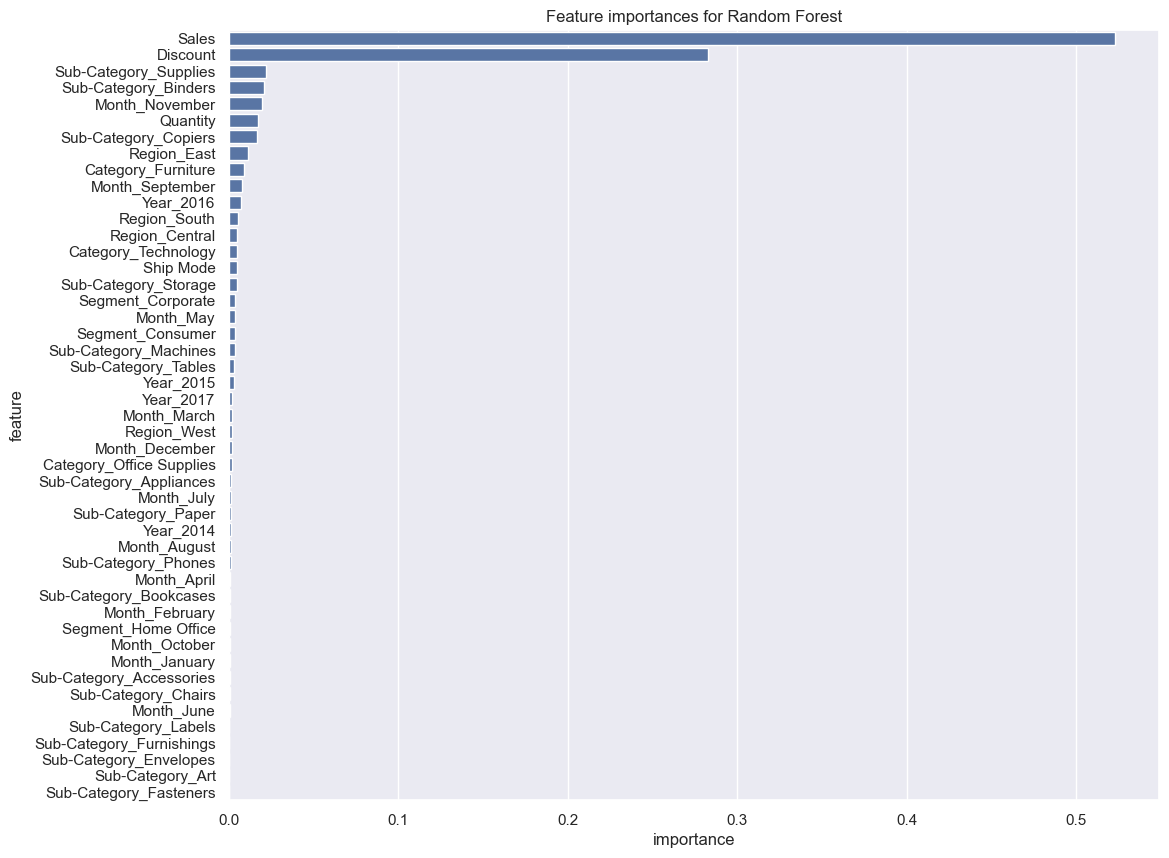

In [59]:
feature_importances = zip(X_train.columns, gs.best_estimator_.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.figure(figsize=(12, 10))
plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

In [80]:
%%time
parameters = {'n_estimators': [5, 10, 50, 100, 500], 
            'max_features' : [None, 3], 
            'max_depth':[None, 3, 5, 10]}

model = RandomForestRegressor()
clf = GridSearchCV(model, parameters, scoring = 'r2')

clf.fit(X_train, y_train)
pred = clf.predict(X_test)


print('Best parameters: ', clf.best_params_)
print(f'Test score: {r2_score(y_test, pred):.4f}')

Best parameters:  {'max_depth': None, 'max_features': None, 'n_estimators': 500}
Test score: 0.8848
CPU times: total: 11min 5s
Wall time: 11min 45s


In [122]:
model = RandomForestRegressor(n_estimators=500, n_jobs=-1)
model.fit(X_train, y_train)
print(f'Actual test score: {r2_score(model.predict(X_test), y_test):.4f}')

Actual test score: 0.3815


In [139]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression 

In [160]:
clf1 = LinearRegression()
clf2 = DecisionTreeRegressor()

estimators = [
    ("LinearRegression", clf1),
    ("DecisionTreeRegressor", clf2)
    ]

# построим классификатор используя стекинг и наш список классификаторов
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(n_jobs=-1),
    n_jobs=-1,
    verbose=True,
)

stacking_regressor.fit(X_train, y_train)
y_pred = stacking_regressor.predict(X_test)
stacking_score = r2_score(y_test, y_pred)

print(f'r2 for the StackingRegressor: {stacking_score:.13f}')

r2 for the StackingRegressor: 1.0000000000000


In [157]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge  # LinearRegression подходит для регрессии
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

# 1. Создаем данные для регрессии
X, y = make_regression(n_samples=100, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Определяем базовые модели (регрессоры!)
estimators = [
    ('lr', LinearRegression()),  # Линейная регрессия
    ('ridge', Ridge(alpha=)),
    ('svr', SVR(kernel='linear'))  # SVR с линейным ядром
]

# 3. Создаем StackingRegressor
reg = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1))

# 4. Обучаем StackingRegressor
reg.fit(X_train, y_train)

# 5. Делаем предсказания
y_pred = reg.predict(X_test)

# 6. Оцениваем производительность
# from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.13f}")
print(f"R2 Score: {r2:.13f}")

Mean Squared Error: 0.0000016166972
R2 Score: 0.9999999999591
